# Preprocess

The preprocessing steps consist of merging all retrieved files into one xarray dataset and extracting the spatial and temporal average of the event of interest.

## Merge

Here it is shown how all retrieved files are loaded into one xarray dataset, for both SEAS5 and for ERA5. 

### SEAS5
All retrieved seasonal forecasts are loaded into one xarray dataset. The amount of files retrieved depends on the temporal extent of the extreme event that is being analyzed (i.e are you looking at a monthly average or a seasonal average?). For the Siberian heatwave, we have retrieved 105 files (one for each of the 35 years and for each of the three lead times, ([see Retrieve](../1.Download/1.Retrieve.ipynb)). For the UK, we are able to use more forecasts, because the target month is shorter: one month as compared to three months for the Siberian example. We retrieved 5 leadtimes x 35 = 175 files.  

Each netcdf file contains 25 ensemble members, hence has the dimensions lat, lon, number (25 ensembles). Here we create an xarray dataset that also contains the dimensions time (35 years) and leadtime (5 initialization months). To generate this, we loop over lead times, and open all 35 years of the lead time and then concatenate those leadtimes.

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
import src.cdsretrieve as retrieve

In [3]:
os.chdir(os.path.abspath('../../../'))
os.getcwd() #print the working directory

'C:\\Users\\Timo\\OneDrive - Loughborough University\\GitHub\\UNSEEN-open'

In [4]:
import xarray as xr
import numpy as np

def merge_SEAS5(folder, target_months):
    init_months, leadtimes = retrieve._get_init_months(target_months)
    print('Lead time: ' + "%.2i" % init_months[0])
    SEAS5_ld1 = xr.open_mfdataset(
        folder + '*' + "%.2i" % init_months[0] + '.nc',
        combine='by_coords')  # Load the first lead time
    SEAS5 = SEAS5_ld1  # Create the xarray dataset to concatenate over
    for init_month in init_months[1:len(init_months)]:  ## Remove the first that we already have
        print(init_month)
        SEAS5_ld = xr.open_mfdataset(
            folder + '*' + "%.2i" % init_month + '.nc',
            combine='by_coords') 
        SEAS5 = xr.concat([SEAS5, SEAS5_ld], dim='leadtime')
    SEAS5 = SEAS5.assign_coords(leadtime = np.arange(len(init_months)) + 2) # assign leadtime coordinates
    return(SEAS5)

In [ ]:
SEAS5_Siberia = merge_SEAS5(folder='../Siberia_example/SEAS5/',
                            target_months=[3, 4, 5])

In [8]:
SEAS5_Siberia

,Array,Chunk
Bytes,387.52 MB,3.31 MB
Shape,"(3, 117, 51, 41, 132)","(1, 3, 51, 41, 132)"
Count,887 Tasks,117 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,387.52 MB,3.31 MB
Shape,"(3, 117, 51, 41, 132)","(1, 3, 51, 41, 132)"
Count,887 Tasks,117 Chunks
Type,float32,numpy.ndarray


You can for example select a the lat, long, time, ensemble member and lead time as follows (add `.load()` to see the values):

In [ ]:
SEAS5_Siberia.sel(latitude=60,
                  longitude=-10,
                  time='2000-03',
                  number=26,
                  leadtime=3).load()

We can repeat this for the UK example, where just February is the target month:

In [10]:
SEAS5_UK = merge_SEAS5(folder = '../UK_example/SEAS5/', target_months = [2])

Lead time: 01
12
11
10
9


The SEAS5 total precipitation rate is in m/s. You can easily convert this and change the attributes.
Click on the show/hide attributes button to see the assigned attributes.

In [11]:
SEAS5_UK['tprate'] = SEAS5_UK['tprate'] * 1000 * 3600 * 24 ## From m/s to mm/d
SEAS5_UK['tprate'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}
SEAS5_UK

,Array,Chunk
Bytes,2.69 MB,15.40 kB
Shape,"(5, 35, 25, 11, 14)","(1, 1, 25, 11, 14)"
Count,1715 Tasks,175 Chunks
Type,float32,numpy.ndarray


### ERA5
For each year a netcdf file is downloaded. They are named ERA5_yyyy, for example ERA5_1981. Therefore, we can load ERA5 by combining all downloaded years:

In [12]:
ERA5_Siberia = xr.open_mfdataset('../Siberia_example/ERA5/ERA5_????.nc',combine='by_coords') ## open the data
ERA5_Siberia

,Array,Chunk
Bytes,2.73 MB,64.94 kB
Shape,"(126, 41, 132)","(3, 41, 132)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.73 MB,64.94 kB
Shape,"(126, 41, 132)","(3, 41, 132)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray


In [13]:
ERA5_UK = xr.open_mfdataset('../UK_example/ERA5/ERA5_????.nc',combine='by_coords') ## open the data
ERA5_UK

,Array,Chunk
Bytes,25.87 kB,616 B
Shape,"(42, 11, 14)","(1, 11, 14)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray


## Event definition

### Time selection
For the UK, the event of interest is UK February average precipitation. Since we download monthly averages, we do not have to do any preprocessing along the time dimension here. For the Siberian heatwave, we are interested in the March-May average. Therefore we need to take the seasonal average of the monthly timeseries. We cannot take the simple mean of the three months, because they have a different number of days in the months, see [this example](http://xarray.pydata.org/en/stable/examples/monthly-means.html). Therefore we take a weighted average:

In [14]:
month_length = SEAS5_Siberia.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 117)>
array([31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30,
       31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31,
       30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31,
       31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30,
       31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31,
       30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31,
       31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 1982-03-01 1982-04-01 ... 2020-05-01

In [15]:
# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
weights

<xarray.DataArray 'days_in_month' (time: 117)>
array([0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652, 0.33695652, 0.32608696, 0.33695652,
       0.33695652, 0.32608696, 0.33695652, 0.33695652, 0.32608696,
       0.33695652, 0.33695652, 0.32608696, 0.33695652, 0.33695652,
       0.32608696, 0.33695652])
Coordinates:
  * time     (time) datetime64[ns] 1982-03-01 1982-04-01 ... 2020-05-01
    year     (time) int64 1982 1982 1982 1983 1983 ... 2019 2019 2020 2020 2020

In [16]:
# Test that the sum of the weights for the season is 1.0
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(39)) ## the weight is one for each year

In [30]:
# Calculate the weighted average
SEAS5_Siberia_weighted = (SEAS5_Siberia * weights).groupby('time.year').sum(dim='time', min_count = 3)
SEAS5_Siberia_weighted

<xarray.Dataset>
Dimensions:    (latitude: 41, leadtime: 3, longitude: 132, number: 51, year: 39)
Coordinates:
  * leadtime   (leadtime) int64 2 3 4
  * latitude   (latitude) float32 70.0 69.0 68.0 67.0 ... 33.0 32.0 31.0 30.0
  * number     (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... 118.0 119.0 120.0
  * year       (year) int64 1982 1983 1984 1985 1986 ... 2017 2018 2019 2020
Data variables:
    t2m        (year, leadtime, number, latitude, longitude) float64 268.8 ... 289.9
    d2m        (year, leadtime, number, latitude, longitude) float64 266.1 ... 286.0

Or as function:

In [31]:
def season_mean(ds, years, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(years))

    # Calculate the weighted average
    return (ds * weights).groupby('time.year').sum(dim='time', min_count = 3)

In [33]:
ERA5_Siberia_weighted = season_mean(ERA5_Siberia, years = 42)
ERA5_Siberia_weighted

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 132, year: 42)
Coordinates:
  * latitude   (latitude) float32 70.0 69.0 68.0 67.0 ... 33.0 32.0 31.0 30.0
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... 118.0 119.0 120.0
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2017 2018 2019 2020
Data variables:
    t2m        (year, latitude, longitude) float64 270.5 270.9 ... 289.1 290.6
    d2m        (year, latitude, longitude) float64 267.1 267.4 ... 283.5 284.7

What is the difference between the mean and weighted mean?

Barely visible the difference

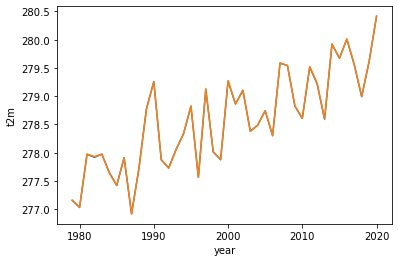

In [34]:
ERA5_Siberia_weighted['t2m'].mean(['longitude', 'latitude']).plot()
ERA5_Siberia['t2m'].groupby('time.year').mean().mean(['longitude','latitude']).plot()

### Spatial selection
What spatial extent defines the event you are analyzing? The easiest option is to select a lat-lon box, like we did for the [Siberian heatwave example](https://unseen-open.readthedocs.io/en/latest/Notebooks/examples/Siberian_Heatwave.html) (i.e we average the temperature over 30-70N, -11-120E). 

In case you want to specify another domain than a lat-lon box, you could mask the datasets. For the [California Fires example](https://unseen-open.readthedocs.io/en/latest/Notebooks/examples/California_Fires.html), we select the domain with high temperature anomalies (>2 standard deviation), see [California_august_temperature_anomaly](https://unseen-open.readthedocs.io/en/latest/Notebooks/California_august_temperature_anomaly.html). For the [UK example](https://unseen-open.readthedocs.io/en/latest/Notebooks/examples/UK_Precipitation.html), we want a country-averaged timeseries instead of a box. In this case, we use another observational product: the EOBS dataset that covers Europe. We *upscale* this dataset to the same resolution as SEAS5 and create a *mask* to take the spatial average over the UK, see [Using EOBS + upscaling](2.3Upscale.ipynb). 

In [35]:
ERA5_Siberia_events = (
    ERA5_Siberia_weighted['t2m'].sel(  # Select 2 metre temperature
        latitude=slice(70, 30),        # Select the latitudes
        longitude=slice(-11, 120)).    # Select the longitude
    mean(['longitude', 'latitude']))   # And average
ERA5_Siberia_events

<xarray.DataArray 't2m' (year: 42)>
array([277.16074991, 277.03096514, 277.97289103, 277.91908656,
       277.97520289, 277.65083809, 277.41882817, 277.91126484,
       276.91748994, 277.7290794 , 278.77625033, 279.26028161,
       277.8734671 , 277.73297789, 278.05803743, 278.33474762,
       278.8209804 , 277.56676759, 279.12484889, 278.01516085,
       277.87531784, 279.26812975, 278.86348174, 279.10661042,
       278.37979554, 278.49025936, 278.74264131, 278.30305153,
       279.58431666, 279.54500525, 278.82677061, 278.60606811,
       279.51421559, 279.21937005, 278.59269493, 279.92328752,
       279.6721145 , 280.00902662, 279.55917477, 278.99138847,
       279.61443777, 280.41497365])
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

In addition to the large domain, we select one more specific domain that faced the highest anomalies, also used [here](https://twitter.com/ClimateFlavors/status/1276092906709880837?s=20)

In [36]:
ERA5_Siberia_events_zoomed = (
    ERA5_Siberia_weighted['t2m'].sel(  # Select 2 metre temperature
        latitude=slice(70, 50),        # Select the latitudes
        longitude=slice(65, 120)).    # Select the longitude
    mean(['longitude', 'latitude']))

And we repeat this for the SEAS5 events

In [37]:
SEAS5_Siberia_events = (
    SEAS5_Siberia_weighted['t2m'].sel(
        latitude=slice(70, 30),  
        longitude=slice(-11, 120)).  
    mean(['longitude', 'latitude']))
SEAS5_Siberia_events.load()

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 't2m' (year: 39, leadtime: 3, number: 51)>
array([[[277.70246026, 277.08011538, 277.05805243, ...,          nan,
                  nan,          nan],
        [276.54063304, 277.63527276, 276.53540684, ...,          nan,
                  nan,          nan],
        [276.94382457, 277.22540106, 277.25375804, ...,          nan,
                  nan,          nan]],

       [[276.68638666, 276.64418409, 276.88169219, ...,          nan,
                  nan,          nan],
        [277.06362955, 277.30470221, 276.49967939, ...,          nan,
                  nan,          nan],
        [276.37166345, 276.63563118, 277.05456392, ...,          nan,
                  nan,          nan]],

       [[277.53103277, 277.49691758, 278.32115366, ...,          nan,
                  nan,          nan],
        [277.53911427, 278.11393678, 277.66278741, ...,          nan,
                  nan,          nan],
        [278.24589375, 277.71341079, 277.3067712 , ...,          nan,
                  nan,          nan]],

       ...,

       [[278.78906418, 278.0626699 , 278.09438675, ..., 278.10947691,
         278.27620377, 278.18620179],
        [278.65929139, 277.33954004, 278.65951576, ..., 278.22959696,
         278.32163068, 278.94724957],
        [278.90689211, 277.9030209 , 279.13818072, ..., 278.76767259,
         279.13397914, 277.76992423]],

       [[278.6218426 , 277.95006232, 278.22900254, ..., 277.56330007,
         277.99480916, 277.66857676],
        [278.39808792, 277.65889255, 277.92266928, ..., 278.39390445,
         277.90353039, 278.01793147],
        [278.63429219, 278.11630486, 278.58465727, ..., 277.7081865 ,
         277.73949614, 278.65482764]],

       [[279.28124227, 278.53474142, 278.47436518, ..., 278.93209185,
         278.11716261, 279.3904762 ],
        [277.77935773, 279.15571385, 279.02168652, ..., 279.25803913,
         278.8991169 , 278.72803803],
        [278.54721722, 278.25816177, 279.65502139, ..., 279.01242149,
         278.80174459, 278.23615329]]])
Coordinates:
  * leadtime  (leadtime) int64 2 3 4
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * year      (year) int64 1982 1983 1984 1985 1986 ... 2016 2017 2018 2019 2020

In [39]:
SEAS5_Siberia_events_zoomed = (
    SEAS5_Siberia_weighted['t2m'].sel(
        latitude=slice(70, 50),  
        longitude=slice(65, 120)).  
    mean(['longitude', 'latitude']))
SEAS5_Siberia_events_zoomed.load()

<xarray.DataArray 't2m' (year: 39, leadtime: 3, number: 51)>
array([[[269.41349502, 267.46724112, 268.92858923, ...,          nan,
                  nan,          nan],
        [267.30541714, 269.45786213, 267.88083134, ...,          nan,
                  nan,          nan],
        [266.70463988, 269.36559057, 267.85380896, ...,          nan,
                  nan,          nan]],

       [[267.65255078, 267.85459971, 267.93397041, ...,          nan,
                  nan,          nan],
        [267.86908721, 269.16875401, 266.25505375, ...,          nan,
                  nan,          nan],
        [267.37705396, 268.0216673 , 269.216725  , ...,          nan,
                  nan,          nan]],

       [[269.11559244, 270.30993792, 268.97992022, ...,          nan,
                  nan,          nan],
        [268.42632866, 270.23730451, 268.14872887, ...,          nan,
                  nan,          nan],
        [269.91675564, 269.37623754, 268.62430776, ...,          nan,
                  nan,          nan]],

       ...,

       [[270.1395106 , 269.2763681 , 269.63408345, ..., 267.98167445,
         270.99148119, 269.2334804 ],
        [269.47838693, 267.62436995, 270.46814617, ..., 269.60061317,
         269.2030878 , 270.34174847],
        [271.39762301, 268.06102893, 271.27933216, ..., 269.56866515,
         270.64943148, 266.36754614]],

       [[269.32829344, 268.54758963, 269.10385302, ..., 268.03762412,
         269.16690743, 268.41760566],
        [269.09579833, 268.27844902, 268.80430384, ..., 269.38437353,
         269.58112924, 269.15390309],
        [269.2755198 , 269.28402279, 270.34429505, ..., 268.05044769,
         269.01128231, 270.09822017]],

       [[271.35447849, 269.73507649, 269.16852164, ..., 270.77523033,
         268.30803885, 271.87237937],
        [269.33923167, 270.81122764, 269.97102764, ..., 272.56708782,
         270.69195734, 269.90622653],
        [270.37695877, 269.72247595, 272.524012  , ..., 270.04026793,
         269.81585811, 267.24061429]]])
Coordinates:
  * leadtime  (leadtime) int64 2 3 4
  * number    (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * year      (year) int64 1982 1983 1984 1985 1986 ... 2016 2017 2018 2019 2020

In [40]:
SEAS5_Siberia_events.to_dataframe().to_csv('Data/SEAS5_Siberia_events.csv')
ERA5_Siberia_events.to_dataframe().to_csv('Data/ERA5_Siberia_events.csv')

In [41]:
SEAS5_Siberia_events_zoomed.to_dataframe().to_csv('Data/SEAS5_Siberia_events_zoomed.csv')
ERA5_Siberia_events_zoomed.to_dataframe().to_csv('Data/ERA5_Siberia_events_zoomed.csv')